In [1]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import torch
import torch.nn as nn
from scipy.stats import skew, kurtosis
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score


Loading NumPy Files

In [2]:
train_msAcc = np.load("train_MSAccelerometer_OpenDoor_RubHands.npy")
train_msGyro = np.load("train_MSGyroscope_OpenDoor_RubHands.npy")
train_labels = np.load("train_labels_OpenDoor_RubHands.npy")

test_msAcc = np.load("test_MSAccelerometer_OpenDoor_RubHands.npy")
test_msGyro = np.load("test_MSGyroscope_OpenDoor_RubHands.npy")
test_labels = np.load("test_labels_OpenDoor_RubHands.npy")


Printing Shapes and Setting Parameters

In [3]:
print(train_msAcc.shape)
print(train_msGyro.shape)
print(train_labels.shape)

print(test_msAcc.shape)
print(test_msGyro.shape)
print(test_labels.shape)


(87, 268, 3)
(87, 268, 3)
(87,)
(90, 268, 3)
(90, 268, 3)
(90,)


Step: Set number of train/test examples and features
We’ll use 8 features per sensor 8   (mean, max, min, std, median, range, skewness, kurtosis) and we have 2 sensors (Accelerometer + Gyroscope), each with 3 axes.

In [4]:

train_num_examples = train_msAcc.shape[0]  # 87
test_num_examples = test_msAcc.shape[0]    # 90

num_features = 8  # mean, max, min, std, median, range, skewness, kurtosis
num_sensors = 2   # Accelerometer + Gyroscope

# Initialize feature arrays: shape (samples, features, axes)
train_features = np.zeros((train_num_examples, num_features * num_sensors, 3))
test_features = np.zeros((test_num_examples, num_features * num_sensors, 3))



Extract Features

In [5]:
def extract_8_features(sensor_data):
    mean_ = np.mean(sensor_data, axis=1)
    max_ = np.max(sensor_data, axis=1)
    min_ = np.min(sensor_data, axis=1)
    std_ = np.std(sensor_data, axis=1)
    median_ = np.median(sensor_data, axis=1)
    range_ = max_ - min_
    skewness_ = skew(sensor_data, axis=1)
    kurtosis_ = kurtosis(sensor_data, axis=1)

    # Stack all features: shape -> (samples, 8 features, 3 axes)
    features = np.stack([mean_, max_, min_, std_, median_, range_, skewness_, kurtosis_], axis=1)
    return features


Train and test feature extraction

In [6]:
train_acc_features = extract_8_features(train_msAcc)
train_gyro_features = extract_8_features(train_msGyro)

# Assign to the big feature array
train_features[:, 0:8, :] = train_acc_features
train_features[:, 8:16, :] = train_gyro_features

test_acc_features = extract_8_features(test_msAcc)
test_gyro_features = extract_8_features(test_msGyro)

# Assign to the big feature array
test_features[:, 0:8, :] = test_acc_features
test_features[:, 8:16, :] = test_gyro_features


Reshaping Feature arrays

In [7]:
train_features_reshaped = train_features.reshape(train_num_examples, -1)
test_features_reshaped = test_features.reshape(test_num_examples, -1)

print("Shape of train features:", train_features_reshaped.shape)  # (samples, 48)
print("Shape of test features:", test_features_reshaped.shape)    # (samples, 48)

Shape of train features: (87, 48)
Shape of test features: (90, 48)


Training SVM

   C = 1.0 
   Average F1-score = 0.9444
   Test accuracy = 94.44 %
   Weighted F1-score = 0.9445
   All F1-scores:
[0.94623656 0.94252874]
   Confusion Matrix:
[[44  4]
 [ 1 41]]
-------------------------------------------------------


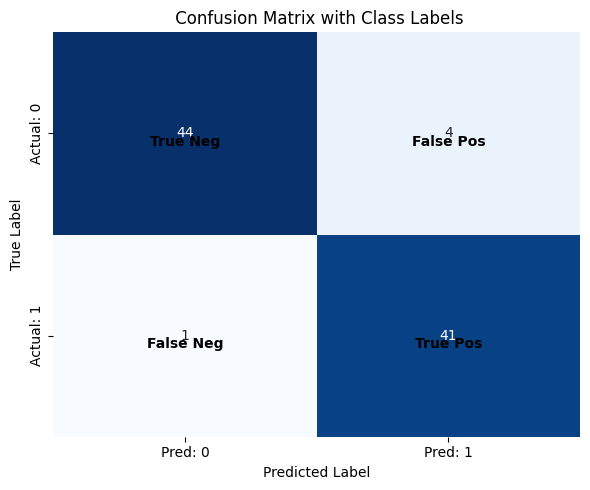

In [9]:
# Initialize SVM classifier with linear kernel
classifier = SVC(C=1.0, kernel='linear', random_state=42)

# Train the classifier
classifier.fit(train_features_reshaped, train_labels)

# Predict on the test set
estimatedLabels = classifier.predict(test_features_reshaped)

# Evaluation metrics
accuracy = accuracy_score(test_labels, estimatedLabels)
weightedF1 = f1_score(test_labels, estimatedLabels, average='weighted')
averageF1 = f1_score(test_labels, estimatedLabels, average='macro')
allF1Scores = f1_score(test_labels, estimatedLabels, average=None)
conf_matrix = confusion_matrix(test_labels, estimatedLabels)

# Print results
print('   C = 1.0 ')
print('   Average F1-score = %.4f' % averageF1)
print('   Test accuracy = %.2f %%' % (accuracy * 100))
print('   Weighted F1-score = %.4f' % weightedF1)
print('   All F1-scores:')
print(allF1Scores)
print('   Confusion Matrix:')
print(conf_matrix)
print('-------------------------------------------------------')

# Plot confusion matrix with class labels
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
plt.figure(figsize=(6, 5))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                 xticklabels=["Pred: 0", "Pred: 1"],
                 yticklabels=["Actual: 0", "Actual: 1"])

# Label the 4 quadrants
for i in range(2):
    for j in range(2):
        label_text = labels[i * 2 + j]
        ax.text(j + 0.5, i + 0.5, f"\n{label_text}", color='black',
                ha='center', va='center', fontsize=10, fontweight='bold')

plt.title(' Confusion Matrix with Class Labels')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()



Convert your numpy arrays to PyTorch tensors

In [11]:
trainingLabels = torch.from_numpy(train_labels).long()
testingLabels = torch.from_numpy(test_labels).long()
trainingLabels[trainingLabels != 0] = 1
testingLabels[testingLabels != 0] = 1

trainingMSAcc = torch.from_numpy(train_msAcc).float()
trainingMSGyro = torch.from_numpy(train_msGyro).float()
trainingLabels = torch.from_numpy(train_labels).long()  # use long for classification labels

testingMSAcc = torch.from_numpy(test_msAcc).float()
testingMSGyro = torch.from_numpy(test_msGyro).float()
testingLabels = torch.from_numpy(test_labels).long()
print(train_msAcc.shape)  # should print (num_samples, time_steps, axes)



(87, 268, 3)


Define a simple CNN model class
We’ll use 1D convolutions since the sensor data is time-series style. For simplicity, concatenate accelerometer and gyroscope along the channel dimension.

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=5)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=5)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        dummy_seq_len = 268  # fixed sequence length based on your data
        dummy_input = torch.zeros(1, 6, dummy_seq_len)

        # forward pass of dummy input to calculate flatten size
        x = self.pool1(F.relu(self.conv1(dummy_input)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        flatten_size = x.numel()  # total features after flattening

        self.fc1 = nn.Linear(flatten_size, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Prepare your dataset loader with batching

In [47]:
# Shape: (samples, time_steps, channels) → concatenate
train_data_np = np.concatenate([train_msAcc, train_msGyro], axis=2)
test_data_np = np.concatenate([test_msAcc, test_msGyro], axis=2)

# Convert to (samples, channels, time_steps)
train_tensor = torch.from_numpy(train_data_np).float().permute(0, 2, 1)
test_tensor = torch.from_numpy(test_data_np).float().permute(0, 2, 1)

train_dataset = TensorDataset(train_tensor, trainingLabels)
test_dataset = TensorDataset(test_tensor, testingLabels)

batchSize = 50
train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False)



Setup training parameters and device and training



In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 150

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")



Epoch [1/150], Loss: 0.1190
Epoch [10/150], Loss: 0.0089
Epoch [20/150], Loss: 0.0043
Epoch [30/150], Loss: 0.0031
Epoch [40/150], Loss: 0.0023
Epoch [50/150], Loss: 0.0017
Epoch [60/150], Loss: 0.0012
Epoch [70/150], Loss: 0.0010
Epoch [80/150], Loss: 0.0008
Epoch [90/150], Loss: 0.0008
Epoch [100/150], Loss: 0.0007
Epoch [110/150], Loss: 0.0006
Epoch [120/150], Loss: 0.0006
Epoch [130/150], Loss: 0.0005
Epoch [140/150], Loss: 0.0005
Epoch [150/150], Loss: 0.0004


Evaluation of model

In [49]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


Printing Accuracy, F1 Score, Report


✅ Test Accuracy: 100.00%

📊 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         0
     Class 1       1.00      1.00      1.00        90

    accuracy                           1.00        90
   macro avg       0.50      0.50      0.50        90
weighted avg       1.00      1.00      1.00        90



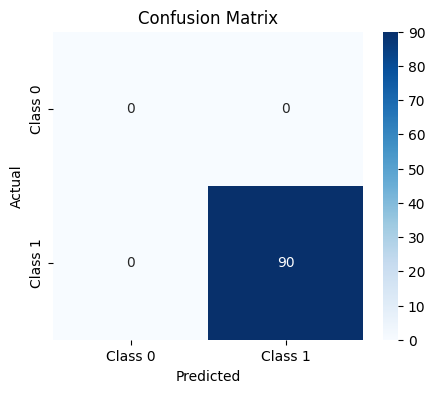

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {accuracy*100:.2f}%")

# Classification Report (force both classes to be shown)
print("\n📊 Classification Report:")
print(classification_report(
    all_labels,
    all_preds,
    labels=[0, 1],  # Force both classes to show up
    target_names=["Class 0", "Class 1"],
    zero_division=0  # Avoid division errors
))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



